![CDS 411 logo](../../img/cds-411-logo.png)

# Class 17: Data-driven modeling IV

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold

Select a random seed for notebook reproducibility.

In [2]:
np.random.seed(9982)

## Recap of model selection

Load the *Filip* dataset.

In [3]:
filip_csv_path = Path("../../data/nist/filip.csv")
filip_df = pd.read_csv(filip_csv_path)

### What are we trying to do?

We considered the problem of selecting a model that best describes the data in the *Filip* dataset.

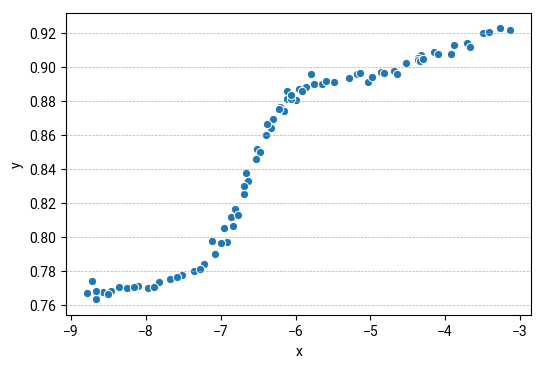

In [4]:
fig, ax = plt.subplots(dpi=100)
sns.scatterplot(x="x", y="y", data=filip_df, ax=ax);

For our space of models, we considered different cut-offs for the polynomial summation:

$$f(x)=\sum_{n}\beta_{n}x^{n}$$

In principle, there is an infinite number of models to choose from, as we can always include more terms in the summation. In practice, we cannot have more terms than datapoints, but even with that restriction, we still have a large number of models to choose from.

**How do we decide which model is best?**

We want to avoid overfitting, which would mean we're starting to fit to the statistical noise inherent in this data. This means we need to strike a balance between explanatory/predictive power and generalizability. We use **cross-validation** to help us compare and rank the models according to how well they achieve this balance.

### Cross-validation

#### What is it?

Cross-validation is a technique used to assess how well a model's predictions generalize to an independent data set. There are different ways to do this. A popular flavor of cross-validation (especially among data scientists) is called **k-fold cross-validation**. The basic idea is to estimate how robust your model is by systematically removing different chunks (the "folds") of the dataset, repeating the fitting process, then testing its predictive power on the folds. The schematic below illustrates the procedure.

![cross validation schematic](../../img/cross-validation-schematic.png)

The above example illustrates a *5-fold*, or $k=5$, cross-validation. Each fold will act as a testing set, with the remaining $k-1$ folds used to train the model. You fit the model using the training set and try to predict values in the current fold, which you quantify by calculating a score, such as the mean-squared prediction error (MSE). The important feature here is that *you are trying to predict data that was **not** used in the training stage*. When cross-validation is completed, you will have a history of scores for each model. The average score for each model can then be compared as a means for ranking and selecting a final model.

#### Why do we use it?

In an ideal setting, you would use your current dataset to train a predictive model, and then test it out by going out and collecting more data and seeing how well the model predicts these new data points. However, there are many reasons in practice that this can be difficult to do. It can be expensive and/or technically difficult to gather new data. It may not be possible to gather new data relevant to the problem at hand. So, we can use methods like cross-validation to overcome some of these problems. Cross-validation also helps us to guard against overfitting. If a model has been overfit, *then it's predictions will be poor for any data points that are not part of the training set*.

#### When should we use it?

Anytime you need to assess the performance and generalizability of a model on unavailable data and a theoretical analysis of the problem is not available. In addition to select between different models, you can also use cross-validation to optimize a single model's internal parameters. This method is an indispensible part of the computational scientist's toolbox.

### Cross-validation code

In [5]:
lm = LinearRegression()

In [6]:
filip_df_poly = filip_df.copy()

for n in np.arange(2, 16):
    filip_df_poly[f"x**{n}"] = filip_df_poly["x"] ** n

In [7]:
independent_var = "y"
dependent_vars = ["x"]

filip_poly_cv_scores = {
    "n": [],
    "mse_trace": [],
    "mse_mean": [],
    "mse_sd": [],
    "r**2_trace": [],
    "r**2_mean": [],
    "r**2_sd": [],
}

In [8]:
for n in range(1, 16):
    if n > 1:
        dependent_vars.append(f"x**{n}")
        
    rkf = RepeatedKFold(
        n_splits=10,
        n_repeats=100,
        random_state=int(np.round(np.random.uniform(0, 2**31), decimals=0)),
    )
    
    # Cross-validated mean-squared error score
    mse_cv_score = cross_val_score(
        lm,
        filip_df_poly[dependent_vars],
        filip_df_poly[independent_var],
        scoring="neg_mean_squared_error",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )

    # Cross-validated R**2 score
    r2_cv_score = cross_val_score(
        lm,
        filip_df_poly[dependent_vars],
        filip_df_poly[independent_var],
        scoring="r2",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )

    filip_poly_cv_scores["n"].append(n)
    filip_poly_cv_scores["mse_trace"].append(mse_cv_score)
    filip_poly_cv_scores["mse_mean"].append(np.mean(mse_cv_score))
    filip_poly_cv_scores["mse_sd"].append(np.std(mse_cv_score))
    filip_poly_cv_scores["r**2_trace"].append(r2_cv_score)
    filip_poly_cv_scores["r**2_mean"].append(np.mean(r2_cv_score))
    filip_poly_cv_scores["r**2_sd"].append(np.std(r2_cv_score))

# Convert dictionary to data frame
filip_poly_cv_scores_df = pd.DataFrame(filip_poly_cv_scores)

### Bootstrapping/resampling

#### What is it?

Bootstrapping is a method for estimating statistical properties by sampling with replacement from the distribution of the available dataset. This method rests on the assumption that the available dataset distribution reasonably approximates the "true" statistical distribution.

A nice visualization of the bootstrapping method is available on *Seeing Theory*: <https://seeing-theory.brown.edu/frequentist-inference/index.html#section3>

#### Why do we use it?

We use bootstrapping when we want to analyze how fluctuations impact statistical properties, for example the mean, median, variance, and so on. It is particularly useful if we do not know the underlying "true" data distribution, or if there are important outliers in our dataset that would be missed by idealizing our distribution. We can use it to construct confidence intervals, which can be used to measure the standard error of a statistical property. It can also be used for statistical inference, for example for running hypothesis tests using *p*-values.

#### When should we use it?

If you want to know how much variation there is in a statistical property and you do not know the "true" underlying data distribution. Even if you do know the underlying distribution, it can be convenient to use bootstrapping in a re-usable workflow that may be applied to different datasets. If you make assumptions about the underlying dataset, you will have to change your code each time the dataset changes. If you use bootstrapping, then you no longer need to do this.

### Bootstrapping code

In [9]:
filip_cv_scores_dist_df = pd.concat(
    [
        pd.DataFrame(filip_poly_cv_scores_df["mse_trace"].tolist()) \
        .assign(n=[f"{x}" for x in range(1, 16)], score="mse") \
        .melt(id_vars=["n", "score"], value_vars=list(range(1000)),
              var_name="cv_run", value_name="value") \
        .sort_values(["score", "n", "cv_run"]) \
        .reset_index(drop=True),
        pd.DataFrame(filip_poly_cv_scores_df["r**2_trace"].tolist()) \
        .assign(n=[f"{x}" for x in range(1, 16)], score="r**2") \
        .melt(id_vars=["n", "score"], value_vars=list(range(1000)),
              var_name="cv_run", value_name="value") \
        .sort_values(["score", "n", "cv_run"]) \
        .reset_index(drop=True),
    ]
)

bootstrap_results = {
    "n": [],
    "sample": [],
    "mean": [],
}

for n in range(2, 16):
    bootstrap_series = filip_cv_scores_dist_df \
        .query(f"score == 'mse' & n == '{n}'") \
        .sample(frac=1000, replace=True).loc[:, "value"]
    bootstrap_df = pd.DataFrame(bootstrap_series) \
        .assign(sample_id=[f"{x}" for x in range(1000) for _ in range(1000)])
    bootstrap_mean_samples = bootstrap_df \
        .groupby(["sample_id"]) \
        .mean() \
        .loc[:, "value"] \
        .values

    bootstrap_results["n"].extend(1000 * [f"{n}"])
    bootstrap_results["sample"].extend(list(range(1000)))
    bootstrap_results["mean"].extend(bootstrap_mean_samples)

filip_cv_scores_bootstrap_df = pd.DataFrame(bootstrap_results)

## Difference between cross-validation and bootstrapping

Cross-validation and bootstrapping share some similar features. Both involve random partitioning of data in some way, and let us see how statistical fluctuations impact our results. Despite these, they are distinct and used for different purposes. We used both in our analysis of the *Filip* dataset.

*   **Cross-valdiation**: We used this to score the predictive power of different polynomial summation models. The output of the cross-validation runs was a history of cross-validation scores for each model, representing different partitionings of the training and test datasets. The average of these runs for a single model yields the cross-validated score for the model, which we use to rank and compare model performance.

*   **Bootstrapping**: We used this to compute the confidence interval of the cross-validated score. This was possible because our cross-validation runs yielded a statistical distribution of scores. **If** (and this is important!) our cross-validated scores were normally distributed, then the 95% confidence interval of the cross-validated score would be given by the formula $\bar{x}\pm{}(\sigma_{\bar{x}}\times{}1.96)$, where $\sigma_{\bar{x}}$ is the standard error:
    
    $$\sigma_{\bar{x}}=\dfrac{\sigma{}}{\sqrt{n}}$$
    
    However, as we saw, some of our distributions **are not** normally distributed, and the confidence interval formula does not hold. Generally, the confidence interval narrows as more samples are included in the average. Finding the 95% confidence interval for our statistical averages lets us assess which of our scores are statistically different from one another.

## Visualizing and reporting the scores

There are two choices for what to use as the error bars when we visualize and report on the statistical distribution of the cross-validated scores:

1.  Use the error bars to represent the overall spread of the cross-validation runs. To show this, you might set the limits of the error bars to be the upper and lower bounds for the middle 95% of the data. This does not require any bootstrapping.

2.  Use the error bars to represent the overall accuracy of the cross-validated scores. To show this, you would compute a confidence interval for the cross-validated scores using bootstrapping.

We compute the error bars for the overall accuracy of the cross-validated scores first:

In [10]:
filip_mse_ci_95 = filip_cv_scores_bootstrap_df \
    .loc[:, ["n", "mean"]] \
    .groupby(["n"]) \
    .quantile([0.025, 0.975])
filip_mse_ci_95 = filip_mse_ci_95["mean"] \
    .unstack() \
    .reset_index() \
    .rename(columns={0.025: "lower", 0.975: "upper"})

filip_cv_final_df = filip_poly_cv_scores_df.copy().loc[:, ["n", "mse_mean"]].query("n > 1")
filip_cv_final_df["n"] = filip_cv_final_df["n"].astype(str)
filip_cv_final_df = filip_cv_final_df.merge(filip_mse_ci_95, on=["n"])

# Error bar lengths are measured relative to the mean
filip_cv_final_df["yerr_lower"] = np.abs(filip_cv_final_df["mse_mean"] - filip_cv_final_df["lower"])
filip_cv_final_df["yerr_upper"] = np.abs(filip_cv_final_df["mse_mean"] - filip_cv_final_df["upper"])

To look at the spread of the cross-validation scores, we just need to compute the lower and upper bounds for the middle 95% of the values in the `filip_cv_scores_dist_df` data frame. The code below finds those percentiles and joins them into the data frame.

In [11]:
filip_cv_final_df = filip_cv_scores_dist_df \
    .query("score == 'mse'") \
    .loc[:, ["n", "value"]] \
    .groupby(["n"]) \
    .quantile([0.025, 0.975]) \
    .loc[:, "value"] \
    .unstack() \
    .reset_index() \
    .rename(columns={0.025: "dist_lower", 0.975: "dist_upper"}) \
    .merge(filip_cv_final_df, on="n") \
    .assign(yerr_dist_lower=lambda x: np.abs(x.dist_lower - x.mse_mean),
            yerr_dist_upper=lambda x: np.abs(x.dist_upper - x.mse_mean),
            n=lambda x: x.n.astype(int)) \
    .sort_values(["n"]) \
    .reset_index(drop=True) \
    .loc[:, ["n", "mse_mean", "lower", "upper", "yerr_lower", "yerr_upper",
             "dist_lower", "dist_upper", "yerr_dist_lower",
             "yerr_dist_upper"]]

The final data frame is as follows:

In [12]:
filip_cv_final_df

,n,mse_mean,lower,upper,yerr_lower,yerr_upper,dist_lower,dist_upper,yerr_dist_lower,yerr_dist_upper
0,2,-0.000299,-0.000307,-0.000292,7.496232e-06,6.931635e-06,-0.000526,-0.000106,0.000227,0.000193
1,3,-0.000220,-0.000225,-0.000216,4.625765e-06,4.364832e-06,-0.000391,-0.000102,0.000171,0.000118
2,4,-0.000092,-0.000095,-0.000090,2.110358e-06,2.291977e-06,-0.000171,-0.000035,0.000079,0.000057
3,5,-0.000098,-0.000101,-0.000095,2.983943e-06,3.335300e-06,-0.000210,-0.000038,0.000112,0.000060
4,6,-0.000040,-0.000042,-0.000039,1.545200e-06,1.482100e-06,-0.000088,-0.000014,0.000047,0.000026
5,7,-0.000042,-0.000044,-0.000040,2.319783e-06,1.887609e-06,-0.000078,-0.000013,0.000036,0.000029
6,8,-0.000034,-0.000039,-0.000030,4.850659e-06,3.850499e-06,-0.000141,-0.000006,0.000106,0.000028
7,9,-0.000025,-0.000028,-0.000022,3.152797e-06,2.498889e-06,-0.000063,-0.000005,0.000038,0.000020
8,10,-0.000024,-0.000028,-0.000020,4.022749e-06,3.580657e-06,-0.000081,-0.000004,0.000058,0.000020
9,11,-0.000015,-0.000016,-0.000014,1.146726e-06,9.722713e-07,-0.000040,-0.000003,0.000025,0.000012


We visualize our mean-squared error scores, this time with proper error bars representing the 95% confidence interval for the mean scores:

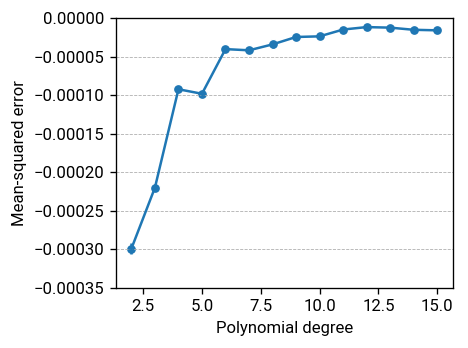

In [13]:
fig, ax = plt.subplots(dpi=120, figsize=(4, 3))
facet_var, facet_id, facet_label, facet_ylim = ("mse", 0, r"Mean-squared error", (-0.00035, 0.0))
sns.scatterplot(
    x="n",
    y=f"{facet_var}_mean",
    data=filip_cv_final_df,
    ax=ax,
)
ax.errorbar(
    filip_cv_final_df["n"],
    filip_cv_final_df[f"{facet_var}_mean"],
    yerr=[filip_cv_final_df["yerr_lower"], filip_cv_final_df["yerr_upper"]],
)
ax.set_ylim(facet_ylim)
ax.set_xlabel(r"Polynomial degree")
ax.set_ylabel(facet_label)

fig.tight_layout();

The error bars are very tiny, smaller than the size of the points.

The visualization below shows the mean-squared error scores along with error bars that represent the spread of the cross-validation results (specifically, the middle 95%).

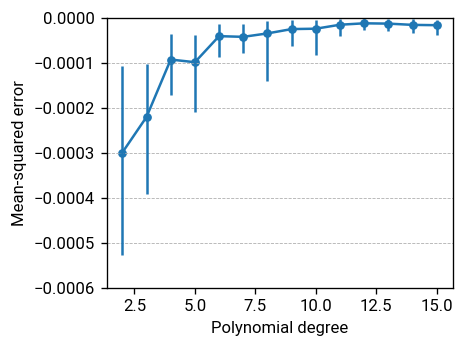

In [14]:
fig, ax = plt.subplots(dpi=120, figsize=(4, 3))
facet_var, facet_id, facet_label, facet_ylim = ("mse", 0, r"Mean-squared error", (-0.0006, 0.0))
sns.scatterplot(
    x="n",
    y=f"{facet_var}_mean",
    data=filip_cv_final_df,
    ax=ax,
)
ax.errorbar(
    filip_cv_final_df["n"],
    filip_cv_final_df[f"{facet_var}_mean"],
    yerr=[filip_cv_final_df["yerr_dist_lower"], filip_cv_final_df["yerr_dist_upper"]],
)
ax.set_ylim(facet_ylim)
ax.set_xlabel(r"Polynomial degree")
ax.set_ylabel(facet_label)

fig.tight_layout();